# Predict bankruptcy

https://www.kaggle.com/c/diciaccio/data

#### В качестве итоговой модели был выбран Грдиентный бустинг, оценка auc-roc на тесте kaggle составила: 0.93585

## Оглавление:<a class='anchor' id='0'></a>
1. [Предобработка данных:](#1)
2. [Логистическая регрессия](#2)
3. [Ядырные методы опорных векторов](#3)
4. [Случайный лес](#4)
5. [Градиентный бустинг](#5)
6. [Сравнение ROC кривых](#6)
6. [Получение прогнозов](#7)
7. [Пользовательские функции](#8)

In [225]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline

In [226]:
data = pd.read_csv('daticctrain.csv', sep=';', low_memory = False)

### 1. Предобработка данных <a class='anchor' id='1'></a>
[в начало](#0)

**Анализ полей и размера выборки**

In [227]:
print('Размер обучающей выборки: {}'.format(data.shape))

Размер обучающей выборки: (11000, 86)


In [228]:
data.head()
# data.tail()

,ID,Target,Anno,Z1,Z2,Regione,Ricavi-1,Ricavi-2,Dipendenti-1,Dipendenti-2,...,TOTALEPAS-1,TOTALEPAS-2,TOTALEDEBITI-1,TOTALEDEBITI-2,Totaldebitientro-1,Totaldebitientro-2,Totaldebitioltre-1,Totaldebitioltre-2,RedditivROI-1,RedditivROI-2
0,7358,0,2016,1.479190,1.695080,VENETO,3 618,3 337,26,24,...,3 491,3 577,1 461,1 137,1 461,1 137,0,0,-25.53,-7.45
1,9744,0,2016,1.547276,1.721152,TRENTINO-ALTO,1 735,1 843,2,2,...,2 244,2 425,855,851,855,851,0,0,10.12,16.51
2,13087,0,2016,1.102310,1.526099,CAMPANIA,1 098,1 166,10,13,...,2 234,1 493,1 580,866,596,584,984,282,4.26,3.54
3,7510,0,2016,3.824231,3.456398,SICILIA,9 187,9 081,44,45,...,3 055,3 336,1 994,2 428,332,1 438,1 662,990,10.68,12.78
4,8450,0,2016,3.082321,2.647675,PUGLIA,2 712,2 426,14,13,...,1 323,1 513,1 074,1 171,963,1 057,110,115,24.54,19.99


Название полей

In [229]:
# data.columns

Типы полей

In [230]:
# data.dtypes[data.dtypes=='object'] # Категории (35)
# data.dtypes[data.dtypes=='int64'] # Целые (3)
# data.dtypes[data.dtypes=='float64'] # Вещественные (48)

Описание полей по типам

In [231]:
# data.describe(include=['object']) # Категории (35)
# data.describe(include=['int64']) # Целые (3)
# data.describe(include=['float64']) # Вещественные (48)

Присутствует несбалансированность классов -> Будем учитывать это при построении моделей (class_weight='balanced')

In [232]:
data.Target.value_counts()

0    10168
1      832
Name: Target, dtype: int64

**Исследуем поля на пропуски**

В данных имеется один пропуск в поле "Z2":

In [233]:
data.isnull().sum()[data.isnull().sum()>0]

Z2    1
dtype: int64

In [234]:
'''Заменим пропуск на среднее значение признака'''
print('среднее значение признака Z2: {:.3f}'.format(data.Z2.mean()))
data.Z2.fillna(data.Z2.mean(), inplace=True)

среднее значение признака Z2: 2.152


In [235]:
# data.isnull().any()[data.isnull().any()==True]

Пропущенных значений больше нет. В тестовых данных так же пропусков нет

**Отделим выборку от целевой метки**

In [236]:
X = data.copy() # сделаем копию выборки
y = X.Target.values # создадим отдельно целевые метки
X.drop(['ID','Target'], axis=1, inplace=True) # удалим ID и Target

In [237]:
data = None

**Предобработка категориальных признаков**

In [238]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [239]:
'''Категориальные признаки'''
columns_object = X.dtypes[X.dtypes=='object'].keys()

In [240]:
# columns_object

**категории:**
Regione

**строки с числами и пробелами между разрядами:**
Ricavi-1, Ricavi-2, Dipendenti-1, Dipendenti-2, EBITDA-1, EBITDA-2, Totale-1, Totale-2, Utile-1, Utile-2
Patrimonio-1, Patrimonio-2, Posizione-1, Posizione-2, ATTIVO_CIR-1, ATTIVO_CIR-2, TOTALE_IMM-1, TOTALE_IMM-2,
TOTALE_CRED-1, TOTALE_CRED-2, Utile_perd-1, Utile_perd-2, TOTALEPAS-1, TOTALEPAS-2, TOTALEDEBITI-1, TOTALEDEBITI-2
Totaldebitientro-1, Totaldebitientro-2, Totaldebitioltre-1, Totaldebitioltre-2,

**вещественные числа в строке с пробелом:**
Rappindeb-1, Rappindeb-2, Durcrediti-1, Durcrediti-2

In [241]:
columns_object_string = list(columns_object) # список категориальных признаков
columns_object_string.remove('Regione') # список строковочисловых признаков

In [242]:
'''преобразование строковых признаков в числовые (для train)'''
ReplaceNumericData(X, columns_object_string)

В итоге остался один категориальный признак: "Regione"

In [243]:
X.dtypes[X.dtypes=='object']

Regione    object
dtype: object

Преобразуем категориальный признак "Regione":

In [244]:
encoder = LabelEncoder()
X['Regione'] = encoder.fit_transform(X['Regione'])

In [245]:
# X.head()

**Матрица попарных корреляций**

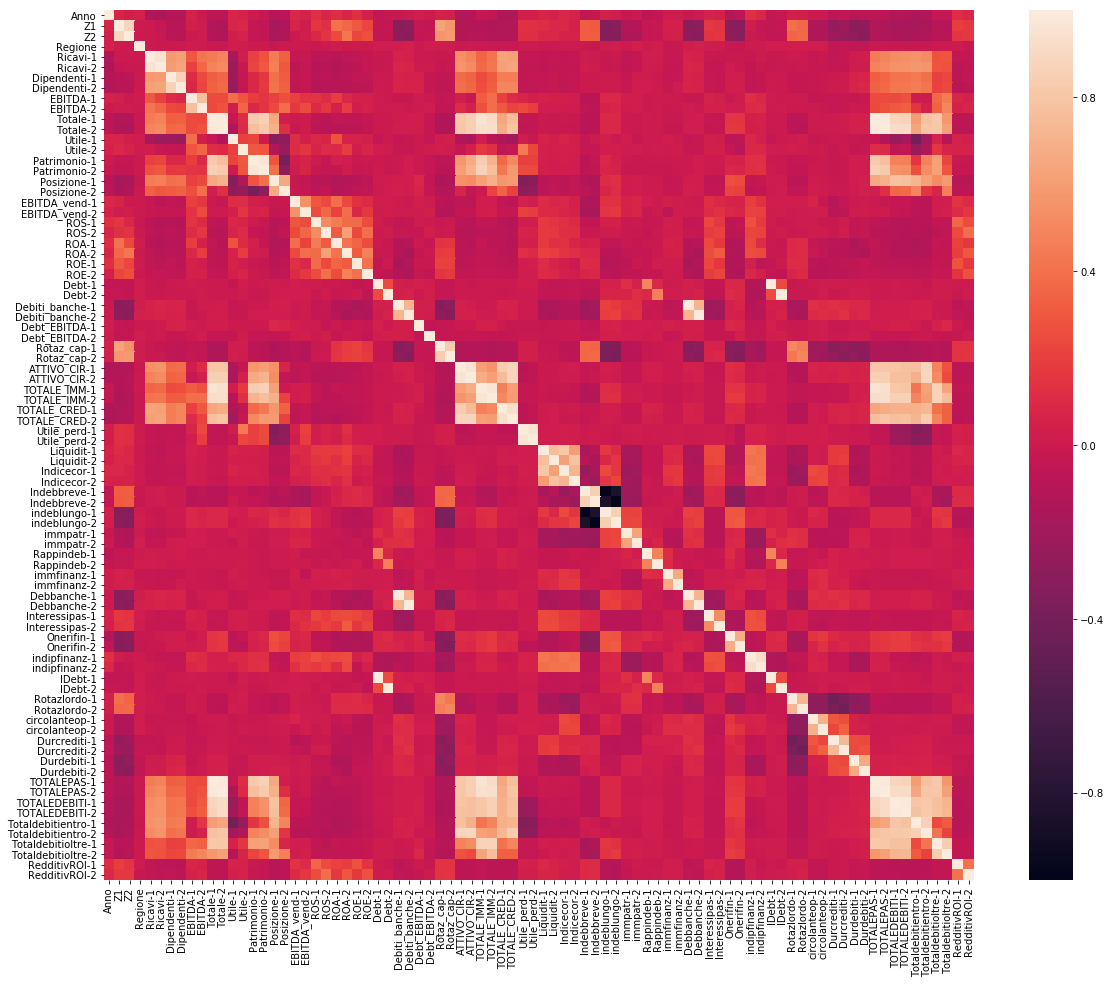

In [246]:
import seaborn
plt.figure(figsize=(20,16))
seaborn.heatmap(X.corr(), square=True)

Как и следовало ожидать, большинство признаков взаимозависимы, однако исключение данных признаков или понижение размерности посредством методов матричного разложения приводят к некоторой потери данных и сказываются на итоговом качестве. Оставим все признаки.

**Исследование признаков на нормальность**

In [247]:
from scipy import stats

In [248]:
X.columns[4]

'Ricavi-1'

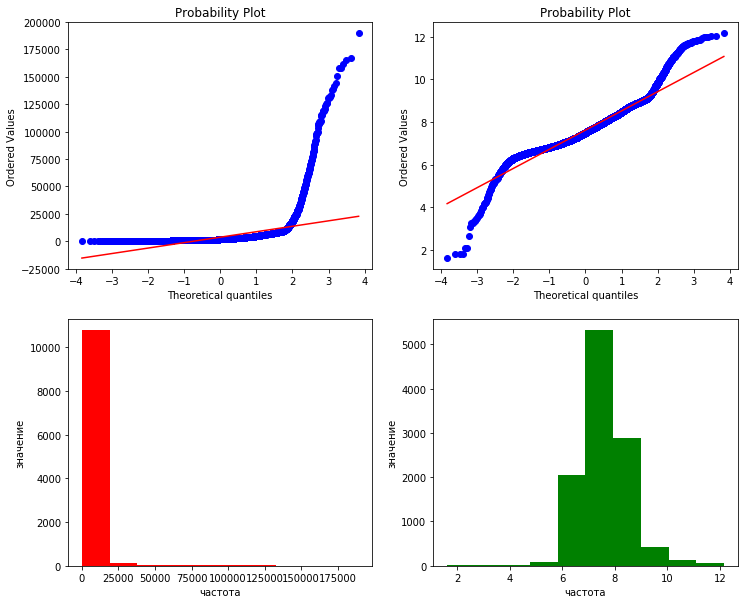

In [251]:
'''Функция построения Q-Q графика и переход к логорифму признака'''
Norm_log_QQ_Plot(X[X.columns[4]])

Были выбраны следующие номера признаков, подлежащие логорифмированию:

In [252]:
Columns = [4,5,6,7,10,11,28,29,32,33,34,35,36,37,38,39,42,43,44,45,56,57,58,59,60,61,66,67,70,71,74,75,76,77,78,79,80]

In [253]:
'''Логорифмирование данных признаков'''
for i in range(len(X.columns)):
    if i in Columns:
        X[X.columns[i]] = X[X.columns[i]].apply(lambda x: np.log(x+1)) # изменим признак на log от этого признака

### 2. Построение модели Логистической регрессии <a class='anchor' id='2'></a>
[в начало](#0)

In [254]:
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler

In [255]:
model_1 = LogisticRegression(random_state = 0, class_weight='balanced')

pip_11 = pipeline.Pipeline([('scaler',MinMaxScaler()),('model',model_1)])
pip_12 = pipeline.Pipeline([('scaler',StandardScaler()),('model',model_1)])

In [256]:
%%time
cross_val_score(pip_11, X, y, scoring='roc_auc', cv=5).mean() # предобработка - масштабирование

Wall time: 2.73 s


0.9706462579715607

In [207]:
%%time
cross_val_score(pip_12, X, y, scoring='roc_auc', cv=5).mean() # предобработка - стандартизация

Wall time: 7.12 s


0.9682365975564367

In [208]:
%%time
pip_11.fit(X,y)
pip_12.fit(X,y)

Wall time: 2.83 s


In [209]:
'''построение графика коээфициентов модели'''
# PltCoefModel(pip_11)

'построение графика коээфициентов модели'

**Подбор параметров по сетке**

In [277]:
param_grid = {'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_11 = GridSearchCV(pip_11, param_grid, scoring='roc_auc', cv=5)
grid_12 = GridSearchCV(pip_12, param_grid, scoring='roc_auc', cv=5)

In [278]:
%%time
grid_11.fit(X,y)

Wall time: 43.2 s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('model', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [279]:
grid_11.grid_scores_

C:\Users\Dima\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.90845, std: 0.01194, params: {'model__C': 0.0001},
 mean: 0.92183, std: 0.01054, params: {'model__C': 0.001},
 mean: 0.94982, std: 0.00764, params: {'model__C': 0.01},
 mean: 0.96576, std: 0.00610, params: {'model__C': 0.1},
 mean: 0.97065, std: 0.00558, params: {'model__C': 1},
 mean: 0.97117, std: 0.00630, params: {'model__C': 10},
 mean: 0.96938, std: 0.00567, params: {'model__C': 100},
 mean: 0.96756, std: 0.00580, params: {'model__C': 1000}]

In [280]:
%%time
grid_12.fit(X,y)

Wall time: 40.4 s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [281]:
grid_12.grid_scores_

C:\Users\Dima\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.95132, std: 0.00872, params: {'model__C': 0.0001},
 mean: 0.96952, std: 0.00590, params: {'model__C': 0.001},
 mean: 0.97263, std: 0.00605, params: {'model__C': 0.01},
 mean: 0.97089, std: 0.00657, params: {'model__C': 0.1},
 mean: 0.96824, std: 0.00584, params: {'model__C': 1},
 mean: 0.96730, std: 0.00555, params: {'model__C': 10},
 mean: 0.96713, std: 0.00554, params: {'model__C': 100},
 mean: 0.96710, std: 0.00554, params: {'model__C': 1000}]

### 3. Построение модели Ядерного метода опрных векторов <a class='anchor' id='3'></a>
[в начало](#0)

In [210]:
from sklearn.svm import LinearSVC, SVC

In [211]:
model_2 = LinearSVC(random_state = 0, class_weight='balanced')

pip_21 = pipeline.Pipeline([('scaler',MinMaxScaler()),('model',model_2)])
pip_22 = pipeline.Pipeline([('scaler',StandardScaler()),('model',model_2)])

In [212]:
%%time
cross_val_score(pip_21, X, y, scoring='roc_auc',cv=5).mean() # предобработка - масштабирование

Wall time: 26.4 s


0.9714867713002885

In [213]:
%%time
cross_val_score(pip_22, X, y, scoring='roc_auc',cv=5).mean() # предобработка - стандартизация

Wall time: 30.2 s


0.963563704624186

In [214]:
%%time
pip_21.fit(X,y)
pip_22.fit(X,y)

Wall time: 15.9 s


Попробуем SVM с нелинейным ядром:

In [215]:
model_3 = SVC(random_state = 0, class_weight='balanced')

pip_3 = pipeline.Pipeline([('scaler',MinMaxScaler()),('model',model_3)])

In [216]:
%%time
cross_val_score(pip_3, X, y, scoring='roc_auc',cv=5).mean()

Wall time: 55.5 s


0.9679646110774588

**Подбор параметров по сетке**

In [168]:
'''оптимизационные параметры в сетке'''
param_grid = {'model__C': [0.001, 0.01, 0.1, 1, 10, 100],  'model__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_3 = GridSearchCV(pip_3, param_grid, scoring='roc_auc', cv=5) # сетка

In [170]:
%%time
grid.fit(X,y)

Wall time: 1h 54min 38s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('model', SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10, 100], 'model__gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Построим график подбора параметров по сетке:

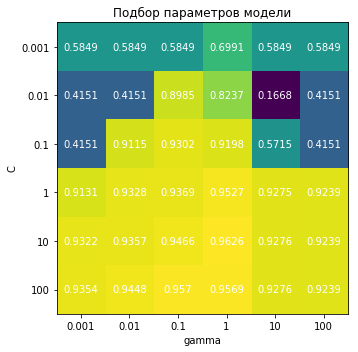

In [320]:
'''визуализация параметров модели по сетке'''
PrintGridParams(grid, param_1='model__C', param_2='model__gamma', color='w')

In [112]:
%%time
model_3 = SVC(random_state = 0, class_weight='balanced', C=10, gamma=1)
pip_3 = pipeline.Pipeline([('scaler',MinMaxScaler()),('model',model_3)])
pip_3.fit(X,y)

Wall time: 6.84 s


Качество SVM с нелинейным ядром уступает линейным моделям. Попробуем модели ансамбли

### 4. Построение модели Случайный лес <a class='anchor' id='4'></a>
[в начало](#0)

In [217]:
from sklearn.ensemble import RandomForestClassifier

In [218]:
model_4 = RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators=100)

Отмечу, что **ансамбли нейтрально отностяся к машстабированию**, в отличии от линейных моделей и методов опорных векторов

In [219]:
%%time
cross_val_score(model_4, X, y, scoring='roc_auc', cv=5).mean() # модель без масштабирования

Wall time: 54.2 s


0.9778837070140307

In [220]:
%%time
model_4.fit(X,y)

Wall time: 14.8 s


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

### 5. Построение модели Градиентный бустинг <a class='anchor' id='5'></a>
[в начало](#0)

In [282]:
from sklearn.ensemble import GradientBoostingClassifier

In [283]:
model_5 = GradientBoostingClassifier(random_state=0, n_estimators=300)

In [223]:
%%time
cross_val_score(model_5, X, y, scoring='roc_auc', cv=5).mean()

Wall time: 2min 57s


0.9799548243348202

**Оптимальное количество деревьев и глубина**

In [358]:
'''подбор количества деревьев'''
estimators = [1] + list(range(5,55,5)) + list(range(100, 500, 100))
scoring_estimators = []

for i in estimators:
    clf = GradientBoostingClassifier(n_estimators=i, random_state=0)
    score = cross_val_score(clf, X, y, scoring='roc_auc', cv=5).mean()
    scoring_estimators.append(score)

In [383]:
'''подбор глубины деревьев'''
depth = [1] + list(range(2,22,2)) + [30]
scoring_depth = []

for i in depth:
    clf = GradientBoostingClassifier(max_depth=i, n_estimators=100, random_state=0)
    score = cross_val_score(clf, X, y, scoring='roc_auc', cv=5).mean()
    scoring_depth.append(score)

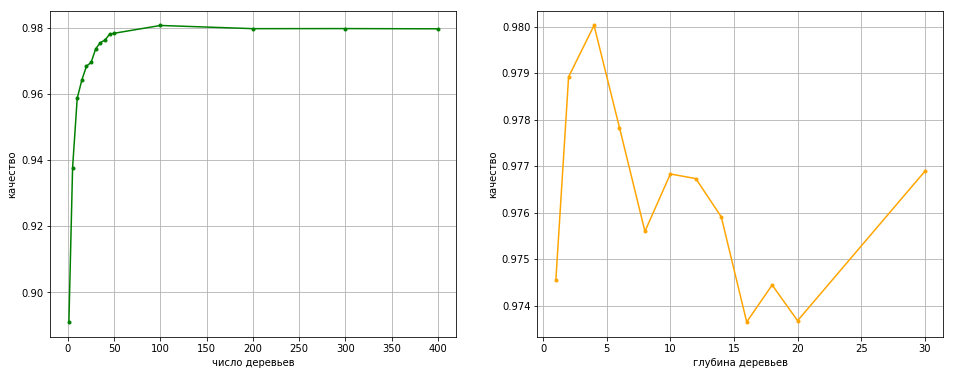

In [384]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(estimators, scoring_estimators, marker='.', color='green', label='Число деревьев')
plt.grid(True)
plt.xlabel('число деревьев')
plt.ylabel('качество')

plt.subplot(1,2,2)
plt.plot(depth, scoring_depth, marker='.', color='orange', label='Глубина деревьев')
plt.grid(True)
plt.xlabel('глубина деревьев')
plt.ylabel('качество')

plt.show()

**Подбор параметров по сетке**

В градиентном бустинге основными параметрами являются: **learning_rate** - степень вклада нового базового алгоритма в ансамбль и **n_estimators** - число деревьев. Имеет смысл подобрать **n_estimators** максимально большим, на сколько это возможно, а затем подбирать под него **learning_rate**

In [301]:
param_grid = {'learning_rate': [0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]}
model_5 = GradientBoostingClassifier(random_state=0, n_estimators=500)
grid_5 = GridSearchCV(model_5, param_grid, scoring='roc_auc', cv=5)

In [302]:
%%time
grid_5.fit(X,y)

Wall time: 44min 37s


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [303]:
grid_5.grid_scores_

C:\Users\Dima\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.96285, std: 0.00668, params: {'learning_rate': 0.0025},
 mean: 0.96974, std: 0.00602, params: {'learning_rate': 0.005},
 mean: 0.97704, std: 0.00395, params: {'learning_rate': 0.0075},
 mean: 0.97864, std: 0.00362, params: {'learning_rate': 0.01},
 mean: 0.98129, std: 0.00413, params: {'learning_rate': 0.025},
 mean: 0.98112, std: 0.00456, params: {'learning_rate': 0.05},
 mean: 0.97940, std: 0.00627, params: {'learning_rate': 0.075},
 mean: 0.97980, std: 0.00591, params: {'learning_rate': 0.1},
 mean: 0.97583, std: 0.00676, params: {'learning_rate': 0.25},
 mean: 0.95275, std: 0.01369, params: {'learning_rate': 0.5},
 mean: 0.94335, std: 0.01527, params: {'learning_rate': 0.75},
 mean: 0.82794, std: 0.08287, params: {'learning_rate': 1}]

Выберем в качестве модели Градиентный бустинг с параметрами: learning_rate=0.1 и n_estimators=200

In [304]:
%%time
model_5 = GradientBoostingClassifier(random_state=0, learning_rate=0.025, n_estimators=500)
model_5.fit(X,y)

Wall time: 1min


### 6.  Сравнение ROC кривых<a class='anchor' id='6'></a>
[в начало](#0)

In [121]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve

In [120]:
'''Разобьем выборку на обучение и тест в отношении 70к30'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

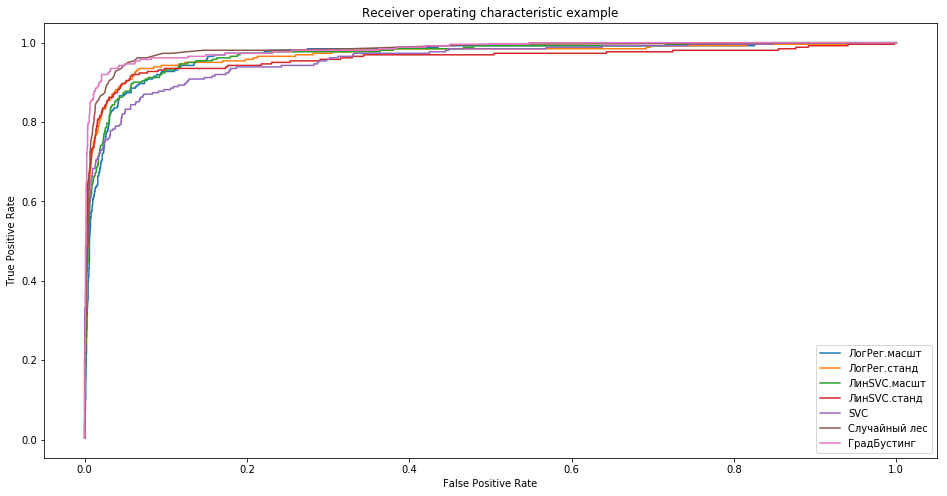

In [131]:
models = [pip_11, pip_12, pip_21, pip_22, pip_3, model_4, model_5]
str_models = ['ЛогРег.масшт', 'ЛогРег.станд', 'ЛинSVC.масшт', 'ЛинSVC.станд', 'SVC', 'Случайный лес', 'ГрадБустинг']

plt.figure(figsize=(16, 8)) 
for model, str_model in zip(models,str_models):
    model.fit(X_train, y_train)
    if (str_model in ['ЛинSVC.масшт', 'ЛинSVC.станд', 'SVC']):
        pred_scr = model.decision_function(X_test)
    else:
        pred_scr = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, pred_scr)
    plt.plot(fpr, tpr, label=str_model)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

Выберем в качестве итоговой модели Градиентный бустинг с параметрами: learning_rate=0.1 и n_estimators=200

### 7. Получение прогнозов на тесте <a class='anchor' id='7'></a>
[в начало](#0)

In [305]:
data_test = pd.read_csv('daticctest1.csv', sep=';', low_memory = False)

In [306]:
# data_test.head()

In [307]:
data_test.drop(['ID'], axis=1, inplace=True)

In [308]:
'''преобразование строковых признаков в числовые (для test)'''
ReplaceNumericData(data_test, columns_object_string)

In [309]:
'''преобразование категориального признака'''
encoder = LabelEncoder()
data_test['Regione'] = encoder.fit_transform(data_test['Regione'])

In [310]:
'''Логорифмирование некоторых признаков'''
for i in range(len(data_test.columns)):
    if i in Columns:
        data_test[data_test.columns[i]] = data_test[data_test.columns[i]].apply(lambda x: np.log(x+1))

In [311]:
# data_test.head()

In [312]:
Model = GradientBoostingClassifier(random_state=0, learning_rate=0.025, n_estimators=500)
Model.fit(X,y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.025, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

In [313]:
test_predict = Model.predict(data_test)

In [314]:
from collections import Counter
Counter(test_predict)

Counter({0: 3714, 1: 252})

**Подгрузка рещультатов**

In [315]:
Test = pd.DataFrame(list(range(1,len(test_predict)+1)) , columns=['id'])
Test['Target'] = test_predict

In [316]:
Test.head()

,id,Target
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [317]:
Test.to_csv('TestADN_GB.csv', sep=',', index=False)
print(Test.shape)

(3966, 2)


#### Посредством градиентного бустинга, оценка auc-roc на тесте kaggle составила: 0.93356

### 8. Пользовательские функции <a class='anchor' id='8'></a>                                                
[в начало](#0)

In [19]:
'''Функция преобразование строковочисловых признаков в численные'''
def ReplaceNumericData(x, columns):
    for c in columns:
        x[c] = x[c].apply(lambda x: x.replace(' ', '')) # удаление пробелов
        x[c] = x[c].apply(pd.to_numeric) # преобразование в число

In [20]:
'''функция построения графика коэффициентов модели'''
def PltCoefModel(pipeline,x=30,y=30):
    plt.figure(figsize=(x,y))
    plt.barh(range(len(X.columns)), abs(pipeline.named_steps['model'].coef_[0]), align='center')
    plt.yticks(range(len(X.columns)), X.columns, size=20)
    plt.xlabel('Модуль значимости признака', size=20)
    plt.show()

In [21]:
'''функция визуализации параметров модели по сетке'''
def PrintGridParams(grid, param_1='model__C', param_2='model__gamma', color='b'):

    values = grid.grid_scores_
    values = [round(values[k][1],4) for k in range(len(values))]
    size = len(values)**0.5 # квадратный корень размера есть сторона квадрата  
    values = np.reshape(values,(size,size)) # преобразование списка в матрицу

    xx = param_grid[param_1]
    yy = param_grid[param_2]

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(values)

    ax.set_xticks(range(len(xx)))
    ax.set_yticks(range(len(yy)))
    ax.set_xticklabels(xx)
    ax.set_yticklabels(yy)
    ax.set_xlabel(param_2)
    ax.set_ylabel(param_1)

    for i in range(len(xx)):
        for j in range(len(yy)):
            text = ax.text(j, i, values[i,j], ha='center', va='center', color=color)

    ax.set_title('Подбор параметров модели')
    fig.tight_layout()
    plt.show()

In [224]:
'''Функция построения Q-Q графика и переход к логорифму признака'''
def Norm_log_QQ_Plot(df):
    plt.figure(figsize=(12,10))
    plt.subplot(2,2,1)
    stats.probplot(df, dist="norm", plot=plt) # Q-Q график для income 
    # plt.title('income')
    plt.subplot(2,2,2)
    stats.probplot(np.log(df+1), dist="norm", plot=plt) # Q-Q график для age
    # plt.title('log_income')
    plt.subplot(2,2,3)
    plt.hist(df, color='red')
    # plt.title('доход')
    plt.xlabel('частота')
    plt.ylabel('значение')
    plt.subplot(2,2,4)
    plt.hist(np.log(df+1), color='green')
    # plt.title('логорифм дохода')
    plt.xlabel('частота')
    plt.ylabel('значение')
    plt.show()

### [в начало](#0)